# Ultimate Takehome Challenge

In [1]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

import warnings
warnings.filterwarnings('ignore')

# Part 1 - Exploratory Data Analysis 

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

Load logins data into pandas dataframe

In [2]:
# load json 'logins' file into dataframe

logins_df = pd.read_json("logins.json")

In [3]:
# make sure the datatype is in 'datetime' format 

logins_df.dtypes

login_time    datetime64[ns]
dtype: object

In order to easily aggregate the login times I will index the dataframe by the time stamp.

In [4]:
# set the login_time column as the new index 

logins_df.set_index('login_time', inplace=True)

In [5]:
# create new column that will count the time-stamps and will be grouped by 15 min intervals 

logins_df['login_count'] = 1

In [6]:
# each time-stamp should have a value of '1'

logins_df

,login_count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1
...,...
1970-04-13 18:50:19,1
1970-04-13 18:43:56,1
1970-04-13 18:54:02,1


In [7]:
# use the 'resample' method along with 'sum' to aggreagte the time-stamps by 15min intervals 

logins_15mins_df = logins_df.resample('15T').sum()

In [8]:
logins_15mins_df

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


In [9]:
# make the login-times a column and reset the index 

logins_15mins_df.index.name = 'time_window'
logins_15mins_df.reset_index(inplace=True)

In [10]:
logins_15mins_df

,time_window,login_count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1
...,...,...
9783,1970-04-13 17:45:00,5
9784,1970-04-13 18:00:00,5
9785,1970-04-13 18:15:00,2
9786,1970-04-13 18:30:00,7


In [11]:
# extract the day of the week and hour from the datetime objects in the 'time window' column

logins_15mins_df['day'] = logins_15mins_df.time_window.dt.day_name()
logins_15mins_df['hour'] = logins_15mins_df.time_window.dt.hour


In [12]:
#examine dataframe

logins_15mins_df

,time_window,login_count,day,hour
0,1970-01-01 20:00:00,2,Thursday,20
1,1970-01-01 20:15:00,6,Thursday,20
2,1970-01-01 20:30:00,9,Thursday,20
3,1970-01-01 20:45:00,7,Thursday,20
4,1970-01-01 21:00:00,1,Thursday,21
...,...,...,...,...
9783,1970-04-13 17:45:00,5,Monday,17
9784,1970-04-13 18:00:00,5,Monday,18
9785,1970-04-13 18:15:00,2,Monday,18
9786,1970-04-13 18:30:00,7,Monday,18


Being that this dataset only spans 3.5 months, I will define 'seasonality' as hourly and daily cycles. Now I am going to aggregate the day and hour columns, to get login counts for each. 15 minute intervals seems a bit granular to be relevant.

In [13]:
# aggregate by day of week 
day_counts = logins_15mins_df.groupby('day').sum()

# drop 'hour' column
day_counts.drop('hour', axis=1, inplace=True)

#sort values from greatest to least
day_counts.sort_values('login_count', ascending=False)

,login_count
day,
Saturday,19377
Sunday,18167
Friday,15208
Thursday,11960
Wednesday,10339
Tuesday,9268
Monday,8823


We can see that the login count increses almost perfectly with the progression of the week, starting on Monday with the lowest count and peaking on Saturday with the highest count. 

In [14]:
# aggregate by hour of day
hour_counts = logins_15mins_df.groupby('hour').sum()

# sort values from greatest to least
hour_counts.sort_values('login_count', ascending=False)


,login_count
hour,
22,6607
1,6317
23,6058
0,5993
2,5800
11,5799
21,5623
4,5034
12,4964


We can see that the most common hours of the day to login in are 10pm, 1am, 11pm, Midnight, and 2am. This makes sense as people usually need a ride when they go out partying/drinking on the weekend. The least common hours are from 5-9am and around 4-6 pm. This suggests that people don't use this app much for commuting. 

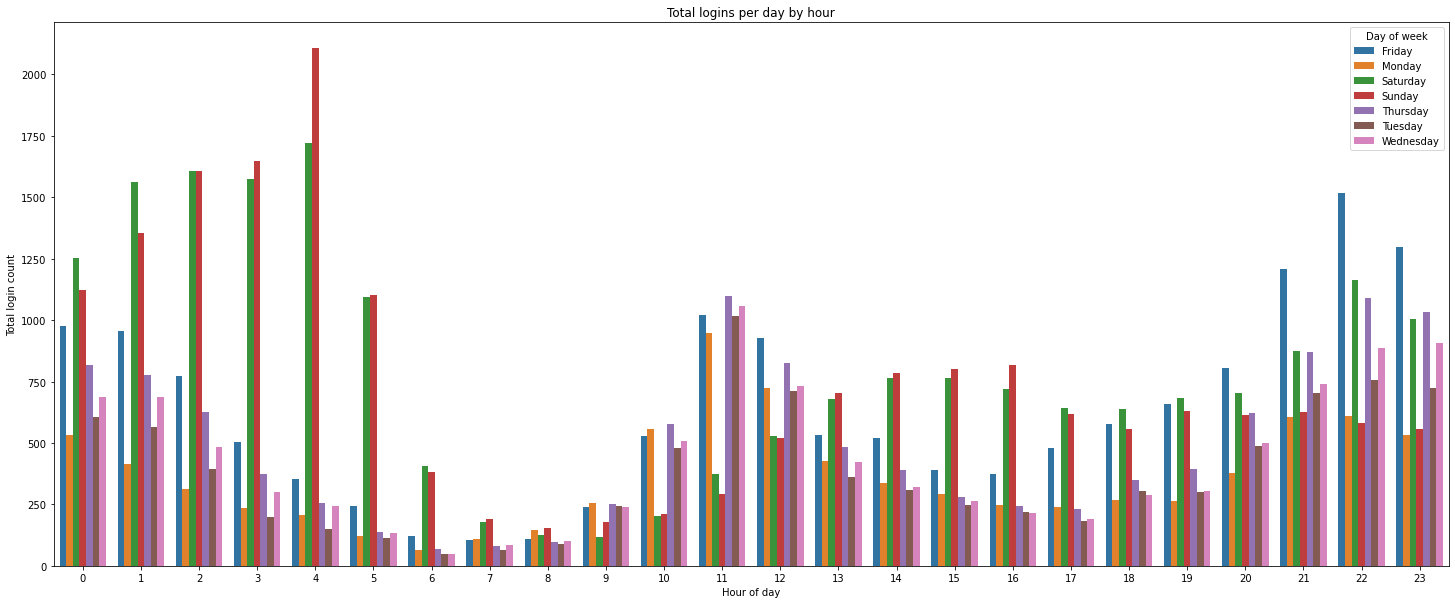

In [15]:
# plot login count by hour of day for each day of the week 

hour_day_df = logins_15mins_df.groupby(['hour', 'day']).sum().reset_index()

fig, ax = plt.subplots(figsize=(25,10))
ax = sns.barplot(x='hour', y='login_count', data=hour_day_df, hue='day')
ax.legend(title='Day of week' ,loc='upper right')
ax.set(xlabel= 'Hour of day', ylabel= 'Total login count', title="Total logins per day by hour")

plt.show()

Now let's plot out the entire time range by day/week

In [16]:
# create new dataframe grouped by daily login count

logins_period_df = logins_df.resample('1D').sum()

In [17]:
# create new column for the date

logins_period_df.index.name = 'date'

# reset the index 
logins_period_df.reset_index(inplace=True)


In [18]:
# create new column for the day of week and new column for month 

logins_period_df['day'] = logins_period_df.date.dt.day_name()

logins_period_df['month'] = logins_period_df.date.dt.month_name()

In [19]:
# extract week number from our date column

logins_period_df['week'] = logins_period_df.date.dt.isocalendar().week

In [20]:
# create new dataframe that sums login counts based on the week count 

weekly_logins_df = logins_period_df.groupby(['week', 'month']).sum().reset_index()

[Text(0.5, 0, 'Week Number'),
 Text(0, 0.5, 'Total login count'),
 Text(0.5, 1.0, 'Total logins per week by month')]

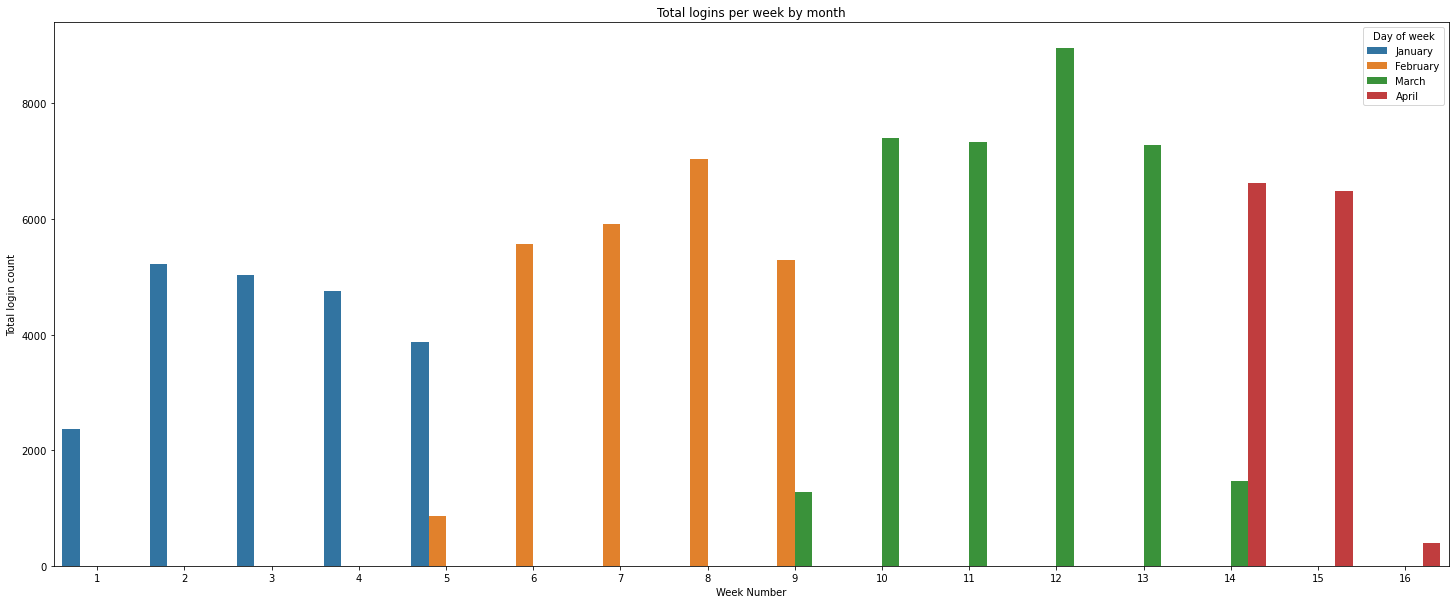

In [21]:
# plot the login counts over the 4 month time period by the week 

fig, ax = plt.subplots(figsize=(25,10))
ax = sns.barplot(x='week', y='login_count', data=weekly_logins_df, hue='month')
ax.legend(title='Day of week' ,loc='upper right')
ax.set(xlabel= 'Week Number', ylabel= 'Total login count', title="Total logins per week by month")

We can see that ridership steadily increases over the 3 moth time window. This could be related to the seasonal shift from winter into spring; weather gets warmer, days get longer and people go out more and become more social. Ridership actually appears to peak right around the time of the daylight savings time shift (clock moving forward) and remains relatively high.